# Mobility visualization

This notebook tries to explore the mobility of the users when applying for jobs. It tries to answer the following questions:

1. Where do people from DE want to go? And from AT or CH?
2. Which regions have more jobs?
3. If we look only at users who are willing to change region, where do they want to go?
4. Visualization of the (user.region, item.region) pair

Can we extract conclusions from these visualisations?

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [3]:
folderData = 'data/'
folderMaps = 'maps/'

Let's import all the interactions of type "replied" (interaction 3). 
If a user has replied to a job posting, I will think it indicates that it is interested in the job, even if the region of the job is far.

In [4]:
#  Import all the interactions of type "replied" (interaction 3)
replied_interactions = pd.read_csv(folderData + 'interactions_replied.csv') 
replied_interactions.reset_index(drop=True)
replied_interactions.head()

,user_id,item_id,interaction_type,created_at
0,518323,890,3,1483473392
1,472504,1190,3,1485419881
2,1790848,1830,3,1483950415
3,803720,1880,3,1483377509
4,803720,1880,3,1485860254


Import all users and items and select those ones that have had an interaction of type 3

In [5]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [6]:
# Import items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [7]:
#Let's reduce sizes of data, only keeping columns of interest for plotting
items = items[['item_id', 'country', 'region', 'latitude', 'longitude']].reset_index(drop=True)
items.head()

,item_id,country,region,latitude,longitude
0,30,de,7,50.8,8.9
1,70,de,1,48.7,9.0
2,80,de,1,48.8,8.1
3,90,de,3,52.5,13.4
4,100,at,0,48.1,15.1


In [8]:
users = users[['user_id', 'country', 'region']].reset_index(drop=True)
users.head()

,user_id,country,region
0,30,de,0
1,50,de,7
2,70,de,2
3,90,de,0
4,100,non_dach,0


In [9]:
# Select only the users who have interaction of type 3, and only those jobs with which they have interacted
interested_users = replied_interactions.user_id.unique()
jobs_of_interest = replied_interactions.item_id.unique()
users = users[users.user_id.isin(interested_users)]
items = items[items.item_id.isin(jobs_of_interest)]

In [10]:
print users.shape
print items.shape

(47828, 3)
(52181, 5)


In [11]:
replied_interactions.head()

,user_id,item_id,interaction_type,created_at
0,518323,890,3,1483473392
1,472504,1190,3,1485419881
2,1790848,1830,3,1483950415
3,803720,1880,3,1483377509
4,803720,1880,3,1485860254


Merge datasets

In [12]:
data = replied_interactions.merge(users, on='user_id', how='outer')
data = data.merge(items, on='item_id', how='outer', suffixes=('_user', '_item'))
data.head()

,user_id,item_id,interaction_type,created_at,country_user,region_user,country_item,region_item,latitude,longitude
0,518323,890,3,1483473392,de,0,de,9,51.2,6.8
1,518323,1037640,3,1478478703,de,0,de,9,51.5,7.0
2,518323,516541,3,1479252937,de,0,de,7,50.2,8.6
3,1109658,516541,3,1478807656,de,0,de,7,50.2,8.6
4,518323,91892,3,1483627535,de,0,at,0,null,null


## Question 1: Where do people from DE want to go? And from AT or CH?

In [13]:
# Select users form each region
user_from_DE = data[data.country_user=='de']
print user_from_DE.shape

user_from_AT = data[data.country_user=='at']
print user_from_AT.shape

user_from_CH = data[data.country_user=='ch']
print user_from_CH.shape

(88081, 10)
(4799, 10)
(8410, 10)


In [14]:
# Give numbers to other destinations that are not Germany
# The DE regions go from 1 to 16, so let's give 17 for AT, 18 for CH and 19 for non_dach
idx = user_from_DE.country_item=='at'
user_from_DE.loc[idx, 'region_item'] = 17
idx = user_from_DE.country_item=='ch'
user_from_DE.loc[idx, 'region_item'] = 18
idx = user_from_DE.country_item=='non_dach'
user_from_DE.loc[idx, 'region_item'] = 19

idx = user_from_AT.country_item=='at'
user_from_AT.loc[idx, 'region_item'] = 17
idx = user_from_AT.country_item=='ch'
user_from_AT.loc[idx, 'region_item'] = 18
idx = user_from_AT.country_item=='non_dach'
user_from_AT.loc[idx, 'region_item'] = 19

idx = user_from_CH.country_item=='at'
user_from_CH.loc[idx, 'region_item'] = 17
idx = user_from_CH.country_item=='ch'
user_from_CH.loc[idx, 'region_item'] = 18
idx = user_from_CH.country_item=='non_dach'
user_from_CH.loc[idx, 'region_item'] = 19

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
# Drop the rows that still have region_item 0 as we do not know where the job post is
user_from_DE = user_from_DE[user_from_DE.region_item>0]
user_from_AT = user_from_AT[user_from_AT.region_item>0]
user_from_CH = user_from_CH[user_from_CH.region_item>0]

In [16]:
# Function to compute popularity of each destination
def create_popularity_regions(users):
    popularity_regions = users.region_item.value_counts()
    popularity_regions = popularity_regions.to_frame()
    popularity_regions.index.name = 'Num'
    popularity_regions.reset_index(inplace=True)
    popularity_regions.columns = ['Num', 'Count']
    return popularity_regions

In [17]:
# Create popularity ranking by users from DE, AT and CH
popularity_regions_from_DE = create_popularity_regions(user_from_DE)
popularity_regions_from_AT = create_popularity_regions(user_from_AT)
popularity_regions_from_CH = create_popularity_regions(user_from_CH)

In [18]:
# Create a dataframe with the name of the regions as they are spelled on our data and on the downloaded maps.
# Add Austria and Switzerland and non_dach as other regions
regions = pd.DataFrame()
regions['Num'] = range(1, 20)
regions['Names'] = ['Baden-Württemberg', 'Bavaria','Berlin','Brandenburg','Bremen','Hamburg','Hesse','Mecklenburg-Vorpommern','Lower Saxony','North Rhine-Westphalia','Rhineland-Palatinate','Saarland','Saxony','Saxony-Anhalt','Schleswig-Holstein','Thuringia', 'AUSTRIA', 'SWITZERLAND', 'Non_dach']
regions['Names_Map'] = ['Baden-W\xc3\xbcrttemberg','Bayern','Berlin','Brandenburg','Bremen','Hamburg','Hessen','Mecklenburg-Vorpommern','Niedersachsen','Nordrhein-Westfalen','Rheinland-Pfalz','Saarland','Sachsen','Sachsen-Anhalt','Schleswig-Holstein','Th\xc3\xbcringen', 'AUSTRIA', 'SWITZERLAND', 'Non_dach']

In [19]:
regions

,Num,Names,Names_Map
0,1,Baden-Württemberg,Baden-Württemberg
1,2,Bavaria,Bayern
2,3,Berlin,Berlin
3,4,Brandenburg,Brandenburg
4,5,Bremen,Bremen
5,6,Hamburg,Hamburg
6,7,Hesse,Hessen
7,8,Mecklenburg-Vorpommern,Mecklenburg-Vorpommern
8,9,Lower Saxony,Niedersachsen
9,10,North Rhine-Westphalia,Nordrhein-Westfalen


In [20]:
# Merge the rgions with the popularity, to have the popularity by region
regions_from_DE = regions.merge(popularity_regions_from_DE, on='Num')
regions_from_AT = regions.merge(popularity_regions_from_AT, on='Num')
regions_from_CH = regions.merge(popularity_regions_from_CH, on='Num')

In [21]:
# Let's sort by count
regions_from_DE = regions_from_DE.sort_values(by='Count')
regions_from_AT = regions_from_AT.sort_values(by='Count')
regions_from_CH = regions_from_CH.sort_values(by='Count')

In [22]:
regions_from_DE.tail()

,Num,Names,Names_Map,Count
8,9,Lower Saxony,Niedersachsen,8983
17,18,SWITZERLAND,SWITZERLAND,10239
2,3,Berlin,Berlin,10697
1,2,Bavaria,Bayern,13325
0,1,Baden-Württemberg,Baden-Württemberg,16046


In [23]:
regions_from_AT.tail()

,Num,Names,Names_Map,Count
1,2,Bavaria,Bayern,325
2,3,Berlin,Berlin,388
0,1,Baden-Württemberg,Baden-Württemberg,600
16,18,SWITZERLAND,SWITZERLAND,820
15,17,AUSTRIA,AUSTRIA,2066


In [24]:
regions_from_CH.tail()

,Num,Names,Names_Map,Count
1,2,Bavaria,Bayern,264
10,12,Saarland,Saarland,269
2,3,Berlin,Berlin,367
0,1,Baden-Württemberg,Baden-Württemberg,970
15,18,SWITZERLAND,SWITZERLAND,6045


### Create a histogram of regions of popularity by users from
1. Germany
2. Austria
3. Switzerland

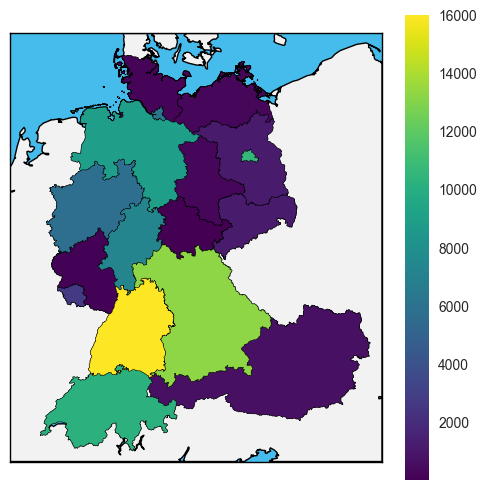

In [25]:
fig, ax = plt.subplots(figsize=(6,6))

m = Basemap(llcrnrlon=5.,llcrnrlat=45.50,urcrnrlon=19.0,urcrnrlat=55.,
             resolution='i', projection='tmerc', lat_0 = 50, lon_0 = 9)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

# Add Germany map with subdivisions
m.readshapefile(folderMaps + 'DEU_adm_shp/DEU_adm1', 'DEU_adm1')
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.DEU_adm1],
        'Names_Map': [area['NAME_1'] for area in m.DEU_adm1_info]
    })

df_poly = df_poly.merge(regions_from_DE, on='Names_Map', how='left')

# Add Austria map
m.readshapefile(folderMaps + 'AUT_adm_shp/AUT_adm0', 'AUT_adm0')
df_poly2 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.AUT_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Num': 17,
        'Names':[area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Count': popularity_regions_from_DE[popularity_regions_from_DE.Num==17].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly2, ignore_index=True)

# Add Switzerland map
m.readshapefile(folderMaps + 'CHE_adm_shp/CHE_adm0', 'CHE_adm0')
df_poly3 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.CHE_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Num': 18,
        'Names':[area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Count': popularity_regions_from_DE[popularity_regions_from_DE.Num==18].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly3, ignore_index=True)

df_poly = df_poly.sort_values(by='Count')

cmap = plt.get_cmap('viridis')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly.Count)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Count'])
plt.colorbar(mapper)

plt.show()

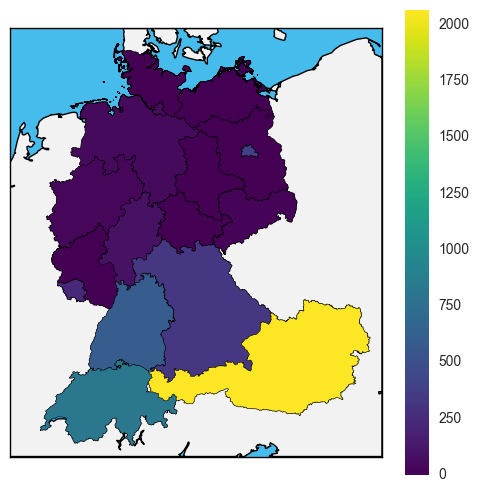

In [26]:
fig, ax = plt.subplots(figsize=(6,6))

m = Basemap(llcrnrlon=5.,llcrnrlat=45.50,urcrnrlon=19.0,urcrnrlat=55.,
             resolution='i', projection='tmerc', lat_0 = 50, lon_0 = 9)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

m.readshapefile(folderMaps + 'DEU_adm_shp/DEU_adm1', 'DEU_adm1')
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.DEU_adm1],
        'Names_Map': [area['NAME_1'] for area in m.DEU_adm1_info]
    })

df_poly = df_poly.merge(regions_from_AT, on='Names_Map', how='left')

m.readshapefile(folderMaps + 'AUT_adm_shp/AUT_adm0', 'AUT_adm0')
df_poly2 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.AUT_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Num': 17,
        'Names':[area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Count': popularity_regions_from_AT[popularity_regions_from_AT.Num==17].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly2, ignore_index=True)

m.readshapefile(folderMaps + 'CHE_adm_shp/CHE_adm0', 'CHE_adm0')
df_poly3 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.CHE_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Num': 18,
        'Names':[area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Count': popularity_regions_from_AT[popularity_regions_from_AT.Num==18].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly3, ignore_index=True)

df_poly.Count.fillna(0, inplace=True)

df_poly = df_poly.sort_values(by='Count')

cmap = plt.get_cmap('viridis')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly.Count)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Count'])
plt.colorbar(mapper)

plt.show()

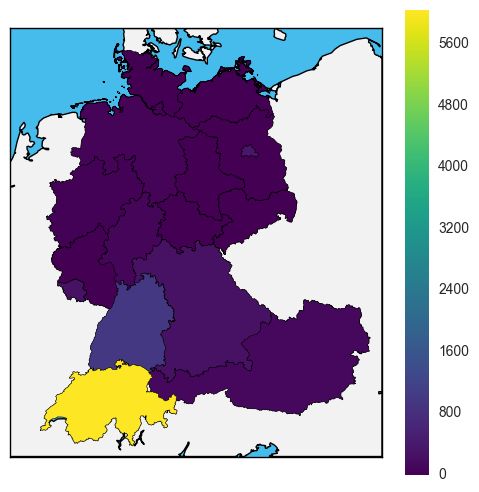

In [27]:
# Add Austria and Switzerland
fig, ax = plt.subplots(figsize=(6,6))

m = Basemap(llcrnrlon=5.,llcrnrlat=45.50,urcrnrlon=19.0,urcrnrlat=55.,
             resolution='i', projection='tmerc', lat_0 = 50, lon_0 = 9)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

m.readshapefile(folderMaps + 'DEU_adm_shp/DEU_adm1', 'DEU_adm1')
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.DEU_adm1],
        'Names_Map': [area['NAME_1'] for area in m.DEU_adm1_info]
    })

df_poly = df_poly.merge(regions_from_CH, on='Names_Map', how='left')

m.readshapefile(folderMaps + 'AUT_adm_shp/AUT_adm0', 'AUT_adm0')
df_poly2 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.AUT_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Num': 17,
        'Names':[area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Count': popularity_regions_from_CH[popularity_regions_from_CH.Num==17].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly2, ignore_index=True)

m.readshapefile(folderMaps + 'CHE_adm_shp/CHE_adm0', 'CHE_adm0')
df_poly3 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.CHE_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Num': 18,
        'Names':[area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Count': popularity_regions_from_CH[popularity_regions_from_CH.Num==18].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly3, ignore_index=True)

df_poly.Count.fillna(0, inplace=True)

df_poly = df_poly.sort_values(by='Count')

cmap = plt.get_cmap('viridis')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly.Count)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Count'])
plt.colorbar(mapper)

plt.show()

People from Germany want to work in:
- Baden-Württemberg
- Bavaria
- Berlin
- Switzerland
- Lower Saxony	Niedersachsen

People from AT want to work in
- Austria
- Switzerland
- Baden-Württemberg

People from Switzerland want to work in
- Switzerland
- Baden-Württemberg

## Question 2: which regions have more jobs?

In [28]:
# The DE regions go from 1 to 16, so let's give 17 for AT, 18 for CH and 19 for non_dach
idx = data.country_item=='at'
data.loc[idx, 'region_item'] = 17
idx = data.country_item=='ch'
data.loc[idx, 'region_item'] = 18
idx = data.country_item=='non_dach'
data.loc[idx, 'region_item'] = 19

In [29]:
# remove the data where region is not specified
regions_all_jobs = data.region_item[data.region_item!=0]
regions_all_jobs.head()

0     9
1     9
2     7
3     7
4    17
Name: region_item, dtype: int64

In [30]:
regions_all_jobs_popularity = regions_all_jobs.value_counts()
regions_all_jobs_popularity = regions_all_jobs_popularity.to_frame()
regions_all_jobs_popularity.index.name = 'Num'
regions_all_jobs_popularity.reset_index(inplace=True)
regions_all_jobs_popularity.columns = ['Num', 'Count']
regions_all_jobs_popularity.head()

,Num,Count
0,1,20407
1,18,19304
2,2,16736
3,3,13451
4,9,10256


In [31]:
# Add region names
regions_all_jobs_popularity = regions.merge(regions_all_jobs_popularity, on='Num')
regions_all_jobs_popularity = regions_all_jobs_popularity.sort_values(by='Count')

In [32]:
regions_all_jobs_popularity

,Num,Names,Names_Map,Count
15,16,Thuringia,Thüringen,66
10,11,Rhineland-Palatinate,Rheinland-Pfalz,145
14,15,Schleswig-Holstein,Schleswig-Holstein,277
13,14,Saxony-Anhalt,Sachsen-Anhalt,365
7,8,Mecklenburg-Vorpommern,Mecklenburg-Vorpommern,422
18,19,Non_dach,Non_dach,498
4,5,Bremen,Bremen,936
3,4,Brandenburg,Brandenburg,1397
12,13,Saxony,Sachsen,1400
16,17,AUSTRIA,AUSTRIA,3616


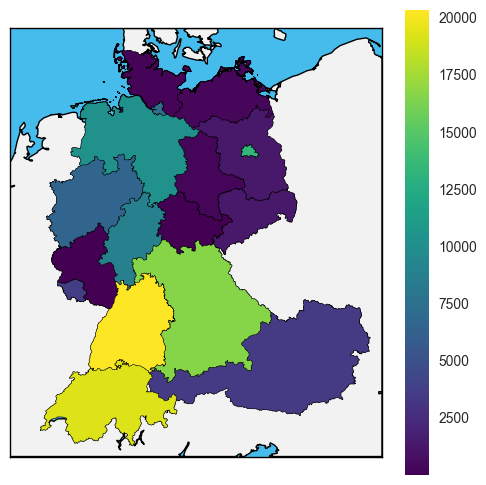

In [33]:
# Plot the number of jobs as a heatmap
fig, ax = plt.subplots(figsize=(6,6))

m = Basemap(llcrnrlon=5.,llcrnrlat=45.50,urcrnrlon=19.0,urcrnrlat=55.,
             resolution='i', projection='tmerc', lat_0 = 50, lon_0 = 9)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

m.readshapefile(folderMaps + 'DEU_adm_shp/DEU_adm1', 'DEU_adm1')
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.DEU_adm1],
        'Names_Map': [area['NAME_1'] for area in m.DEU_adm1_info]
    })

df_poly = df_poly.merge(regions_all_jobs_popularity, on='Names_Map', how='left')

m.readshapefile(folderMaps + 'AUT_adm_shp/AUT_adm0', 'AUT_adm0')
df_poly2 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.AUT_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Num': 17,
        'Names':[area['NAME_ISO'] for area in m.AUT_adm0_info],
        'Count': regions_all_jobs_popularity[regions_all_jobs_popularity.Num==17].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly2, ignore_index=True)

m.readshapefile(folderMaps + 'CHE_adm_shp/CHE_adm0', 'CHE_adm0')
df_poly3 = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.CHE_adm0],
        'Names_Map': [area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Num': 18,
        'Names':[area['NAME_ISO'] for area in m.CHE_adm0_info],
        'Count': regions_all_jobs_popularity[regions_all_jobs_popularity.Num==18].Count.iloc[0],
    })
df_poly = df_poly.append(df_poly3, ignore_index=True)

df_poly.Count.fillna(0, inplace=True)

df_poly = df_poly.sort_values(by='Count')

cmap = plt.get_cmap('viridis')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly.Count)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Count'])
plt.colorbar(mapper)

plt.show()

The regions with more jobs are:

1. Baden-Württemberg
2. Switzerland
3. Bavaria
4. Berlin

## Question 3: where do users who want to change location want to go?

In [34]:
# The DE regions go from 1 to 16, so let's give 17 for AT, 18 for CH and 19 for non_dach
idx = data.country_user=='at'
data.loc[idx, 'region_user'] = 17
idx = data.country_user=='ch'
data.loc[idx, 'region_user'] = 18
idx = data.country_user=='non_dach'
data.loc[idx, 'region_user'] = 19

In [35]:
# Select the users who have applied to other regions
users_loc_change = data[(data.region_user!= data.region_item) & (data.region_user!=0) & (data.region_item!=0)]
users_loc_change.shape

(50529, 10)

In [36]:
# Print the top 5 destinations for each region
for k in range(1, 20):
    print users_loc_change[users_loc_change.region_user==k].region_item.value_counts().head(n=5)

18    1325
3      976
2      717
7      460
12     267
Name: region_item, dtype: int64
1     1600
18    1118
3      888
12     406
7      322
Name: region_item, dtype: int64
18    573
1     405
2     264
12    249
10     87
Name: region_item, dtype: int64
18    195
3     136
1     121
12     57
9      26
Name: region_item, dtype: int64
18    301
1      67
3      62
9      31
6      30
Name: region_item, dtype: int64
18    1233
1      497
3      395
12     173
2      168
Name: region_item, dtype: int64
18    1403
1      896
3      501
2      446
12     286
Name: region_item, dtype: int64
1     41
12    37
3     22
18    19
9     10
Name: region_item, dtype: int64
1     1389
18    1340
3     1028
10     589
2      391
Name: region_item, dtype: int64
18    664
1     573
9     563
3     359
2     170
Name: region_item, dtype: int64
18    22
2     11
9      9
1      9
10     6
Name: region_item, dtype: int64
1     25
18    22
3     12
2     10
10     5
Name: region_item, dtype: int64
3     

Switzerland is always in top 5 for all regions

In [37]:
non_dach = data[data.country_user=='non_dach']

In [43]:
non_dach.region_item.value_counts()

2     2822
1     2791
18    2200
3     1999
7     1383
9     1157
6     1044
10     762
17     707
12     469
0      417
19     223
4      193
13     136
5       78
8       74
15      33
14      31
11      22
16      12
Name: region_item, dtype: int64

## Question 4: (user,job) flux:
Now, let's try to do a chord diagram

In [37]:
# Get original data
data.head()

,user_id,item_id,interaction_type,created_at,country_user,region_user,country_item,region_item,latitude,longitude
0,518323,890,3,1483473392,de,0,de,9,51.2,6.8
1,518323,1037640,3,1478478703,de,0,de,9,51.5,7.0
2,518323,516541,3,1479252937,de,0,de,7,50.2,8.6
3,1109658,516541,3,1478807656,de,0,de,7,50.2,8.6
4,518323,91892,3,1483627535,de,0,at,17,null,null


In [38]:
# Drop the ones where region is still 0 as we do not know preferences
data = data[(data.region_item>0) & (data.region_user>0)]

In [39]:
# Count how many pairs region_item, region_user appear in the data, to determine how popular the pair is
region_region = data[['interaction_type', 'region_user', 'region_item']].groupby(['region_user', 'region_item']).count().reset_index()
region_region.columns = ['region_user', 'region_item', 'Count']

In [40]:
region_region.head()

,region_user,region_item,Count
0,1,1,5383
1,1,2,717
2,1,3,976
3,1,4,37
4,1,5,4


In [41]:
# Merge the dataframe region_region with the region dataframe that contains the names of the regions
regions_route = pd.merge(region_region, regions[['Num', 'Names']], left_on='region_user', right_on='Num')
regions_route = pd.merge(regions_route, regions[['Num', 'Names']], left_on='region_item', right_on='Num', suffixes=('_user', '_item'))

In [42]:
import seaborn as sns
# Create a color palette with 19 colours
p = sns.color_palette("RdYlBu", 19)
p

[(0.73933104069037703, 0.088581315291381607, 0.15086505778451831),
 (0.83929258649141159, 0.18454440685704504, 0.15286428870053897),
 (0.8988850477153365, 0.30549788411330009, 0.20676663566304815),
 (0.95686274427993645, 0.42745097758723249, 0.26274510890829778),
 (0.974855823520971, 0.55740099217240024, 0.32272203168654656),
 (0.99146481758583027, 0.67735485222100489, 0.37808534523607745),
 (0.99407920030757402, 0.77846981485913869, 0.4707420220653693),
 (0.99607843137254903, 0.87843136810788924, 0.56470589731253651),
 (0.99807766243752405, 0.94040753556324486, 0.6586697573663638),
 (0.99761630213292718, 0.99907727824500403, 0.75340255113896504),
 (0.94040755332317905, 0.97693195612510153, 0.85859283120850194),
 (0.87843140877928527, 0.9529411904952072, 0.97254896795050017),
 (0.77247215132675162, 0.90096118040425999, 0.94256056035678792),
 (0.66635908725536164, 0.84759706736803186, 0.91188004060875361),
 (0.55640139625834184, 0.75963092672508581, 0.86389850934896484),
 (0.45490198918

In [43]:
regions['color'] = p.as_hex()
regions.head()

,Num,Names,Names_Map,color
0,1,Baden-Württemberg,Baden-Württemberg,#bd1726
1,2,Bavaria,Bayern,#d62f27
2,3,Berlin,Berlin,#e54e35
3,4,Brandenburg,Brandenburg,#f46d43
4,5,Bremen,Bremen,#f98e52


In [44]:
# Save a CSV file with the name of the region and a corresponding colour
regions[['Names', 'color']].to_csv('regions_colors_all.csv', index=False)

In [45]:
# function to create an adjacency matrix
def adj_matrix(edge_u, edge_v, count, n):
    
    adjMatrix = [[0 for i in range(n)] for k in range(n)]

    # scan the arrays edge_u and edge_v
    for i in range(len(edge_u)):
        u = edge_u[i]
        v = edge_v[i]
        adjMatrix[u-1][v-1] = count[i]
    
    return adjMatrix

In [46]:
# Create adjacency matrtix
n = len(regions_route.region_user.unique())
adjMatrix = adj_matrix(regions_route.region_user, regions_route.region_item, regions_route.Count, n)

In [47]:
# Save the adjacency matrix as a json file
import json
with open('adjacency_matrix_all.json', 'w') as outfile:
    json.dump(adjMatrix, outfile)

In [48]:
%%html
<style>

@import url(style.css);
 
#circle circle {
fill: none;
pointer-events: all;
}
 
.group path {
fill-opacity: .5;
}
 
path.chord {
stroke: #000;
stroke-width: .25px;
}
 
#circle:hover path.fade {
display: none;
}
 
</style>

<div id="chord_all"></div>

In [49]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths: {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
    
    var width = 720,
    height = 720,
    outerRadius = Math.min(width, height) / 2 - 10,
    innerRadius = outerRadius - 24;

    var formatPercent = d3.format(".1%");

    var arc = d3.svg.arc()
    .innerRadius(innerRadius)
    .outerRadius(outerRadius);

    var layout = d3.layout.chord()
    .padding(.04)
    .sortSubgroups(d3.descending)
    .sortChords(d3.ascending);

    var path = d3.svg.chord()
    .radius(innerRadius);

    var svg = d3.select("#chord_all").append("svg")
    .attr("width", width)
    .attr("height", height)
    .append("g")
    .attr("id", "circle")
    .attr("transform", "translate(" + width / 2 + "," + height / 2 + ")");

    svg.append("circle")
    .attr("r", outerRadius);

    d3.csv("regions_colors_all.csv", function(cities) {
    d3.json("adjacency_matrix_all.json", function(matrix) {

    // Compute the chord layout.
    layout.matrix(matrix);

    // Add a group per neighborhood.
    var group = svg.selectAll(".group")
    .data(layout.groups)
    .enter().append("g")
    .attr("class", "group")
    .on("mouseover", mouseover);

    // Add a mouseover title.
    group.append("title").text(function(d, i) {
    return cities[i].Names ;
     });

    // Add the group arc.
    var groupPath = group.append("path")
    .attr("id", function(d, i) { return "group" + i; })
    .attr("d", arc)
    .style("fill", function(d, i) { return cities[i].color; });

    // Add a text label.
    var groupText = group.append("text")
    .attr("x", 6)
    .attr("dy", 15);

    groupText.append("textPath")
    .attr("xlink:href", function(d, i) { return "#group" + i; })
    .text(function(d, i) { return cities[i].Names; });

    // Remove the labels that don't fit. :(
    groupText.filter(function(d, i) { return groupPath[0][i].getTotalLength() / 2 - 16 < this.getComputedTextLength(); })
    .remove();

    // Add the chords.
    var chord = svg.selectAll(".chord")
    .data(layout.chords)
    .enter().append("path")
    .attr("class", "chord")
    .style("fill", function(d) { return cities[d.source.index].color; })
    .attr("d", path);

    // Add an elaborate mouseover title for each chord.
     chord.append("title").text(function(d) {
     return cities[d.source.index].Names
     + " → " + cities[d.target.index].Names
     + ": " + d.source.value
     + "\n" + cities[d.target.index].Names
     + " → " + cities[d.source.index].Names
     + ": " + d.target.value;
     });

    function mouseover(d, i) {
    chord.classed("fade", function(p) {
    return p.source.index != i
    && p.target.index != i;
    });
    }
    });
    });

    
});

<IPython.core.display.Javascript object>

Let's visualize it on a map:

Routes mobility

In [50]:
capitals = pd.DataFrame()
capitals['State'] = ['Baden-Württemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hesse', 'Mecklenburg-Vorpommern',
                     'Lower Saxony', 'North Rhine-Westphalia', 'Rhineland-Palatinate', 'Saarland', 'Saxony',
                    'Saxony-Anhalt', 'Schleswig-Holstein', 'Thuringia']
capitals['Names'] = ['Stuttgart', 'Munich', 'Berlin', 'Potsdam', 'Bremen', 'Hamburg', 'Wiesbaden', 'Hanover', 
                   'Dusseldorf', 'Schwerin', 'Mainz', 'Saarbrucken', 'Dresden', 'Magdeburg', 'Kiel', 'Erfurt']
capitals['Lon'] = [9.1770200, 11.576124, 13.404954, 13.0656600, 8.806422, 9.9936825, 8.2397615, 11.4131600, 9.735603,
                  6.7761600, 8.2791000, 6.9816500, 13.7383200, 11.6291600, 10.1348900, 11.0328300]
capitals['Lat'] = [48.7823200, 48.137154, 52.520008, 52.3988600, 53.073635, 53.551086, 50.078217, 53.6293700,52.373920,
                  51.2217200, 49.9841900, 49.2354000, 51.0508900, 52.1277300, 54.3213300, 50.9787000]

In [51]:
capitals['region'] = capitals.index+1

In [52]:
capitals.head()

,State,Names,Lon,Lat,region
0,Baden-Württemberg,Stuttgart,9.177020,48.782320,1
1,Bavaria,Munich,11.576124,48.137154,2
2,Berlin,Berlin,13.404954,52.520008,3
3,Brandenburg,Potsdam,13.065660,52.398860,4
4,Bremen,Bremen,8.806422,53.073635,5


Select only German users, and from those ones, only the ones who have applied for jobs in other regions in Germany

In [53]:
dataDE = data[(data.country_user=='de') & (data.country_item=='de')]

In [54]:
dataDE_mobility = dataDE[(dataDE.region_item!=0) & (dataDE.region_user!=0) &
                        (dataDE.region_item!=dataDE.region_user) & (dataDE.latitude!='null') & (dataDE.longitude!='null')]
dataDE_mobility.shape

(20751, 10)

In [55]:
dataDE_mobility = dataDE_mobility[['region_user', 'latitude', 'longitude', 'region_item']]

Merge the data with the capitals, in order to have the latitude and longitude of origin and destination. We are assumin that the origin is the capital of the state, as the coordinates of the user are not specified, only the state.

In [56]:
dataDE_mobility = dataDE_mobility.merge(capitals, left_on='region_user', right_on='region')

In [57]:
dataDE_mobility.head()

,region_user,latitude,longitude,region_item,State,Names,Lon,Lat,region
0,1,48.1,11.6,2,Baden-Württemberg,Stuttgart,9.17702,48.78232,1
1,1,50.1,8.7,7,Baden-Württemberg,Stuttgart,9.17702,48.78232,1
2,1,53.6,10.0,6,Baden-Württemberg,Stuttgart,9.17702,48.78232,1
3,1,53.6,10.0,6,Baden-Württemberg,Stuttgart,9.17702,48.78232,1
4,1,51.9,8.4,9,Baden-Württemberg,Stuttgart,9.17702,48.78232,1


Plot 200 random routes

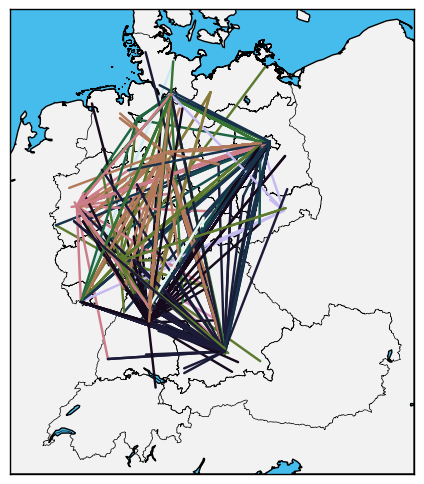

In [58]:
fig, ax = plt.subplots(figsize=(6,6))

m = Basemap(llcrnrlon=5.,llcrnrlat=45.50,urcrnrlon=19.0,urcrnrlat=55.,
             resolution='i', projection='tmerc', lat_0 = 50, lon_0 = 9)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

m.readshapefile(folderMaps + 'DEU_adm_shp/DEU_adm1', 'DEU_adm1')
m.readshapefile(folderMaps + 'AUT_adm_shp/AUT_adm0', 'AUT_adm0')
m.readshapefile(folderMaps + 'CHE_adm_shp/CHE_adm0', 'CHE_adm0')
p = sns.color_palette("cubehelix", 16)

def plot_line(lon, lat, n):
    x, y = m(lon, lat)
    m.plot(x, y, marker=None, color=p[n-1])
    
n = np.random.randint(len(dataDE_mobility), size=500)
dataDE_mobility.ix[n].apply(lambda x: plot_line([x.Lon, float(x.longitude)], [x.Lat, float(x.latitude)], x.region_user), axis=1);


plt.show()

## Preliminary conclusions

1. Users from GERMANY want to go to Baden-Wurttenberg, Bayern, Berlin and Switzerland. We will need to explore region by region looking at the chord chart

2. Users from AUSTRIA want to stay in Austria or go to Switzerland or even Baden-Wurttenberg

3. Users from SWITZERLAND want to stay in Switzerland